## Introduction

This notebook provides background ideas of [the cost minimization notebook](https://www.kaggle.com/saitodevel01/indoor-post-processing-by-cost-minimization).
Honestly, I was a little wondering about the reaction of the notebook.
This method is equivalent to the Kalman smoother under a probabilistic model, neither magic nor trick.
But formulation as an optimization problem is more flexible, it is easy to combine other heuristics such that
["Snap to Grid"](https://www.kaggle.com/robikscube/indoor-navigation-snap-to-grid-post-processing).
And, understanding the probabilistic model behind the cost function allows you to improve post-processing method.

## Prediction Accuracy: Wi-Fi vs Sensors

In the early stage of the competition, the accuracy of the wifi model of the public notebooks was about 8m.
And, in the late stage of the competition, [this discussion](https://www.kaggle.com/c/indoor-location-navigation/discussion/232995)
suggests that the accuracy of top participants' wifi models (without post-processing) is about 5 to 6m.
On the other hand, predicting distances between waypoints using sensor data is much more accurate than pure wifi model.
This figure shows a histogram of the prediction error of $\Delta \hat{X}$
defined in [my notebook](https://www.kaggle.com/saitodevel01/indoor-post-processing-by-cost-minimization).
The average error is about 2.7m, and you can get much better results using machine learning.
This suggests that, if the position of the previous waypoint is known,
predicting the position of the next waypoint from sensor data is more accurate than predicting from wifi model.
A problem is, in test-case, any waypoint is not given, so you must predict at least initial position by other method anyway.
And, using only sensor data will result in significantly worse results because the prediction error is accumulated.


In [ ]:
!pip install kaleido

In [ ]:
import re
import json
import glob
from dataclasses import dataclass
import multiprocessing
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import scipy.signal as signal
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

INPUT_PATH = '../input/indoor-location-navigation'

@dataclass
class ReadData:
    startTime   : int
    endTime     : int
    acce        : np.ndarray
    acce_uncali : np.ndarray
    gyro        : np.ndarray
    gyro_uncali : np.ndarray
    magn        : np.ndarray
    magn_uncali : np.ndarray
    ahrs        : np.ndarray
    wifi        : np.ndarray
    ibeacon     : np.ndarray
    waypoint    : np.ndarray

re_LINE_HEADER = re.compile('\\d{13}\tTYPE_')
def to_logical_lines(line):
    mutch_list = list(re.finditer(re_LINE_HEADER, line))
    assert(len(mutch_list) > 0)
    index_list = [m.start() for m in mutch_list] + [len(line)]
    logical_lines = (line[index_list[i]:index_list[i+1]] for i in range(len(index_list)-1))
    for logical_line in logical_lines:
        yield logical_line
    return

def read_data_file(data_filename, is_test=False):
    acce = list()
    acce_uncali = list()
    gyro = list()
    gyro_uncali = list()
    magn = list()
    magn_uncali = list()
    ahrs = list()
    wifi = list()
    ibeacon = list()
    waypoint = list()
    startTime = None
    endTime   = None

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line in lines:
        line = line.strip()
        if line.startswith('#\tstartTime'):
            startTime = int(re.split('[:\t]', line)[2])
            continue
        if line.startswith('#\tendTime'):
            endTime = int(re.split('[:\t]', line)[2])
            continue
        if (not line) or line.startswith('#'):
            continue
        for line_data in to_logical_lines(line):
            line_data = line_data.split('\t')

            if line_data[1] == 'TYPE_ACCELEROMETER':
                acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
                continue

            if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
                if len(line_data) > 5:
                    acce_uncali.append([int(line_data[0]),
                                        float(line_data[2]), # x
                                        float(line_data[3]), # y
                                        float(line_data[4]), # z
                                        float(line_data[5]), # x
                                        float(line_data[6]), # y
                                        float(line_data[7]), # z
                                        int(  line_data[8]), # accuracy
                                        ])
                else:
                    acce_uncali.append([int(line_data[0]),
                                        float(line_data[2]), # x
                                        float(line_data[3]), # y
                                        float(line_data[4]), # z
                                        ])
                continue

            if line_data[1] == 'TYPE_GYROSCOPE':
                gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
                continue

            if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
                if len(line_data) > 5:
                    gyro_uncali.append([int(line_data[0]),
                                        float(line_data[2]), # x
                                        float(line_data[3]), # y
                                        float(line_data[4]), # z
                                        float(line_data[5]), # x
                                        float(line_data[6]), # y
                                        float(line_data[7]), # z
                                        int(  line_data[8]), # accuracy
                                        ])
                else:
                    gyro_uncali.append([int(line_data[0]),
                                        float(line_data[2]), # x
                                        float(line_data[3]), # y
                                        float(line_data[4]), # z
                                        ])
                continue

            if line_data[1] == 'TYPE_MAGNETIC_FIELD':
                magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
                continue

            if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
                if len(line_data) > 5:
                    magn_uncali.append([int(line_data[0]),
                                        float(line_data[2]), # x
                                        float(line_data[3]), # y
                                        float(line_data[4]), # z
                                        float(line_data[5]), # x
                                        float(line_data[6]), # y
                                        float(line_data[7]), # z
                                        int(  line_data[8]), # accuracy
                                        ])
                else:
                    magn_uncali.append([int(line_data[0]),
                                        float(line_data[2]), # x
                                        float(line_data[3]), # y
                                        float(line_data[4]), # z
                                        ])
                continue

            if line_data[1] == 'TYPE_ROTATION_VECTOR':
                ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
                continue

            if line_data[1] == 'TYPE_WIFI':
                sys_ts = line_data[0]
                ssid = line_data[2]
                bssid = line_data[3]
                rssi = line_data[4]
                lastseen_ts = line_data[6]
                wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
                wifi.append(wifi_data)
                continue

            if line_data[1] == 'TYPE_BEACON':
                ts = line_data[0]
                uuid = line_data[2]
                major = line_data[3]
                minor = line_data[4]
                rssi = line_data[6]
                if is_test:
                    real_ts = line_data[9]
                    ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi, real_ts]
                else:
                    ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
                ibeacon.append(ibeacon_data)
                continue

            if line_data[1] == 'TYPE_WAYPOINT':
                waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])
                continue

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(startTime, endTime, acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

def split_ts_seq(ts_seq, sep_ts):
    """

    :param ts_seq:
    :param sep_ts:
    :return:
    """
    tss = ts_seq[:, 0].astype(float)
    unique_sep_ts = np.unique(sep_ts)
    ts_seqs = []
    start_index = 0
    for i in range(0, unique_sep_ts.shape[0]):
        end_index = np.searchsorted(tss, unique_sep_ts[i], side='right')
        if start_index == end_index:
            continue
        ts_seqs.append(ts_seq[start_index:end_index, :].copy())
        start_index = end_index

    # tail data
    if start_index < ts_seq.shape[0]:
        ts_seqs.append(ts_seq[start_index:, :].copy())

    return ts_seqs


def correct_trajectory(original_xys, end_xy):
    """

    :param original_xys: numpy ndarray, shape(N, 2)
    :param end_xy: numpy ndarray, shape(1, 2)
    :return:
    """
    corrected_xys = np.zeros((0, 2))

    A = original_xys[0, :]
    B = end_xy
    Bp = original_xys[-1, :]

    angle_BAX = np.arctan2(B[1] - A[1], B[0] - A[0])
    angle_BpAX = np.arctan2(Bp[1] - A[1], Bp[0] - A[0])
    angle_BpAB = angle_BpAX - angle_BAX
    AB = np.sqrt(np.sum((B - A) ** 2))
    ABp = np.sqrt(np.sum((Bp - A) ** 2))

    corrected_xys = np.append(corrected_xys, [A], 0)
    for i in np.arange(1, np.size(original_xys, 0)):
        angle_CpAX = np.arctan2(original_xys[i, 1] - A[1], original_xys[i, 0] - A[0])

        angle_CAX = angle_CpAX - angle_BpAB

        ACp = np.sqrt(np.sum((original_xys[i, :] - A) ** 2))

        AC = ACp * AB / ABp

        delta_C = np.array([AC * np.cos(angle_CAX), AC * np.sin(angle_CAX)])

        C = delta_C + A

        corrected_xys = np.append(corrected_xys, [C], 0)

    return corrected_xys


def correct_positions(rel_positions, reference_positions):
    """

    :param rel_positions:
    :param reference_positions:
    :return:
    """
    rel_positions_list = split_ts_seq(rel_positions, reference_positions[:, 0])
    if len(rel_positions_list) != reference_positions.shape[0] - 1:
        # print(f'Rel positions list size: {len(rel_positions_list)}, ref positions size: {reference_positions.shape[0]}')
        del rel_positions_list[-1]
    assert len(rel_positions_list) == reference_positions.shape[0] - 1

    corrected_positions = np.zeros((0, 3))
    for i, rel_ps in enumerate(rel_positions_list):
        start_position = reference_positions[i]
        end_position = reference_positions[i + 1]
        abs_ps = np.zeros(rel_ps.shape)
        abs_ps[:, 0] = rel_ps[:, 0]
        # abs_ps[:, 1:3] = rel_ps[:, 1:3] + start_position[1:3]
        abs_ps[0, 1:3] = rel_ps[0, 1:3] + start_position[1:3]
        for j in range(1, rel_ps.shape[0]):
            abs_ps[j, 1:3] = abs_ps[j-1, 1:3] + rel_ps[j, 1:3]
        abs_ps = np.insert(abs_ps, 0, start_position, axis=0)
        corrected_xys = correct_trajectory(abs_ps[:, 1:3], end_position[1:3])
        corrected_ps = np.column_stack((abs_ps[:, 0], corrected_xys))
        if i == 0:
            corrected_positions = np.append(corrected_positions, corrected_ps, axis=0)
        else:
            corrected_positions = np.append(corrected_positions, corrected_ps[1:], axis=0)

    corrected_positions = np.array(corrected_positions)

    return corrected_positions


def init_parameters_filter(sample_freq, warmup_data, cut_off_freq=2):
    order = 4
    filter_b, filter_a = signal.butter(order, cut_off_freq / (sample_freq / 2), 'low', False)
    zf = signal.lfilter_zi(filter_b, filter_a)
    _, zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)
    _, filter_zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)

    return filter_b, filter_a, filter_zf


def get_rotation_matrix_from_vector(rotation_vector):
    q1 = rotation_vector[0]
    q2 = rotation_vector[1]
    q3 = rotation_vector[2]

    if rotation_vector.size >= 4:
        q0 = rotation_vector[3]
    else:
        q0 = 1 - q1*q1 - q2*q2 - q3*q3
        if q0 > 0:
            q0 = np.sqrt(q0)
        else:
            q0 = 0

    sq_q1 = 2 * q1 * q1
    sq_q2 = 2 * q2 * q2
    sq_q3 = 2 * q3 * q3
    q1_q2 = 2 * q1 * q2
    q3_q0 = 2 * q3 * q0
    q1_q3 = 2 * q1 * q3
    q2_q0 = 2 * q2 * q0
    q2_q3 = 2 * q2 * q3
    q1_q0 = 2 * q1 * q0

    R = np.zeros((9,))
    if R.size == 9:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0

        R[3] = q1_q2 + q3_q0
        R[4] = 1 - sq_q1 - sq_q3
        R[5] = q2_q3 - q1_q0

        R[6] = q1_q3 - q2_q0
        R[7] = q2_q3 + q1_q0
        R[8] = 1 - sq_q1 - sq_q2

        R = np.reshape(R, (3, 3))
    elif R.size == 16:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0
        R[3] = 0.0

        R[4] = q1_q2 + q3_q0
        R[5] = 1 - sq_q1 - sq_q3
        R[6] = q2_q3 - q1_q0
        R[7] = 0.0

        R[8] = q1_q3 - q2_q0
        R[9] = q2_q3 + q1_q0
        R[10] = 1 - sq_q1 - sq_q2
        R[11] = 0.0

        R[12] = R[13] = R[14] = 0.0
        R[15] = 1.0

        R = np.reshape(R, (4, 4))

    return R


def get_orientation(R):
    flat_R = R.flatten()
    values = np.zeros((3,))
    if np.size(flat_R) == 9:
        values[0] = np.arctan2(flat_R[1], flat_R[4])
        values[1] = np.arcsin(-flat_R[7])
        values[2] = np.arctan2(-flat_R[6], flat_R[8])
    else:
        values[0] = np.arctan2(flat_R[1], flat_R[5])
        values[1] = np.arcsin(-flat_R[9])
        values[2] = np.arctan2(-flat_R[8], flat_R[10])

    return values


def compute_steps(acce_datas):
    step_timestamps = np.array([])
    step_indexs = np.array([], dtype=int)
    step_acce_max_mins = np.zeros((0, 4))
    sample_freq = 50
    window_size = 22
    low_acce_mag = 0.6
    step_criterion = 1
    interval_threshold = 250

    acce_max = np.zeros((2,))
    acce_min = np.zeros((2,))
    acce_binarys = np.zeros((window_size,), dtype=int)
    acce_mag_pre = 0
    state_flag = 0

    warmup_data = np.ones((window_size,)) * 9.81
    filter_b, filter_a, filter_zf = init_parameters_filter(sample_freq, warmup_data)
    acce_mag_window = np.zeros((window_size, 1))

    # detect steps according to acceleration magnitudes
    for i in np.arange(0, np.size(acce_datas, 0)):
        acce_data = acce_datas[i, :]
        acce_mag = np.sqrt(np.sum(acce_data[1:] ** 2))

        acce_mag_filt, filter_zf = signal.lfilter(filter_b, filter_a, [acce_mag], zi=filter_zf)
        acce_mag_filt = acce_mag_filt[0]

        acce_mag_window = np.append(acce_mag_window, [acce_mag_filt])
        acce_mag_window = np.delete(acce_mag_window, 0)
        mean_gravity = np.mean(acce_mag_window)
        acce_std = np.std(acce_mag_window)
        mag_threshold = np.max([low_acce_mag, 0.4 * acce_std])

        # detect valid peak or valley of acceleration magnitudes
        acce_mag_filt_detrend = acce_mag_filt - mean_gravity
        if acce_mag_filt_detrend > np.max([acce_mag_pre, mag_threshold]):
            # peak
            acce_binarys = np.append(acce_binarys, [1])
            acce_binarys = np.delete(acce_binarys, 0)
        elif acce_mag_filt_detrend < np.min([acce_mag_pre, -mag_threshold]):
            # valley
            acce_binarys = np.append(acce_binarys, [-1])
            acce_binarys = np.delete(acce_binarys, 0)
        else:
            # between peak and valley
            acce_binarys = np.append(acce_binarys, [0])
            acce_binarys = np.delete(acce_binarys, 0)

        if (acce_binarys[-1] == 0) and (acce_binarys[-2] == 1):
            if state_flag == 0:
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1
            elif (state_flag == 1) and ((acce_data[0] - acce_max[0]) <= interval_threshold) and (
                    acce_mag_filt > acce_max[1]):
                acce_max[:] = acce_data[0], acce_mag_filt
            elif (state_flag == 2) and ((acce_data[0] - acce_max[0]) > interval_threshold):
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1

        # choose reasonable step criterion and check if there is a valid step
        # save step acceleration data: step_acce_max_mins = [timestamp, max, min, variance]
        step_flag = False
        if step_criterion == 2:
            if (acce_binarys[-1] == -1) and ((acce_binarys[-2] == 1) or (acce_binarys[-2] == 0)):
                step_flag = True
        elif step_criterion == 3:
            if (acce_binarys[-1] == -1) and (acce_binarys[-2] == 0) and (np.sum(acce_binarys[:-2]) > 1):
                step_flag = True
        else:
            if (acce_binarys[-1] == 0) and acce_binarys[-2] == -1:
                if (state_flag == 1) and ((acce_data[0] - acce_min[0]) > interval_threshold):
                    acce_min[:] = acce_data[0], acce_mag_filt
                    state_flag = 2
                    step_flag = True
                elif (state_flag == 2) and ((acce_data[0] - acce_min[0]) <= interval_threshold) and (
                        acce_mag_filt < acce_min[1]):
                    acce_min[:] = acce_data[0], acce_mag_filt
        if step_flag:
            step_timestamps = np.append(step_timestamps, acce_data[0])
            step_indexs = np.append(step_indexs, [i])
            step_acce_max_mins = np.append(step_acce_max_mins,
                                           [[acce_data[0], acce_max[1], acce_min[1], acce_std ** 2]], axis=0)
        acce_mag_pre = acce_mag_filt_detrend

    return step_timestamps, step_indexs, step_acce_max_mins


def compute_stride_length(step_acce_max_mins):
    K = 0.4
    K_max = 0.8
    K_min = 0.4
    para_a0 = 0.21468084
    para_a1 = 0.09154517
    para_a2 = 0.02301998

    stride_lengths = np.zeros((step_acce_max_mins.shape[0], 2))
    k_real = np.zeros((step_acce_max_mins.shape[0], 2))
    step_timeperiod = np.zeros((step_acce_max_mins.shape[0] - 1, ))
    stride_lengths[:, 0] = step_acce_max_mins[:, 0]
    window_size = 2
    step_timeperiod_temp = np.zeros((0, ))

    # calculate every step period - step_timeperiod unit: second
    for i in range(0, step_timeperiod.shape[0]):
        step_timeperiod_data = (step_acce_max_mins[i + 1, 0] - step_acce_max_mins[i, 0]) / 1000
        step_timeperiod_temp = np.append(step_timeperiod_temp, [step_timeperiod_data])
        if step_timeperiod_temp.shape[0] > window_size:
            step_timeperiod_temp = np.delete(step_timeperiod_temp, [0])
        step_timeperiod[i] = np.sum(step_timeperiod_temp) / step_timeperiod_temp.shape[0]

    # calculate parameters by step period and acceleration magnitude variance
    k_real[:, 0] = step_acce_max_mins[:, 0]
    k_real[0, 1] = K
    for i in range(0, step_timeperiod.shape[0]):
        k_real[i + 1, 1] = np.max([(para_a0 + para_a1 / step_timeperiod[i] + para_a2 * step_acce_max_mins[i, 3]), K_min])
        k_real[i + 1, 1] = np.min([k_real[i + 1, 1], K_max]) * (K / K_min)

    # calculate every stride length by parameters and max and min data of acceleration magnitude
    stride_lengths[:, 1] = np.max([(step_acce_max_mins[:, 1] - step_acce_max_mins[:, 2]),
                                   np.ones((step_acce_max_mins.shape[0], ))], axis=0)**(1 / 4) * k_real[:, 1]

    return stride_lengths


def compute_headings(ahrs_datas):
    headings = np.zeros((np.size(ahrs_datas, 0), 2))
    for i in np.arange(0, np.size(ahrs_datas, 0)):
        ahrs_data = ahrs_datas[i, :]
        rot_mat = get_rotation_matrix_from_vector(ahrs_data[1:])
        azimuth, pitch, roll = get_orientation(rot_mat)
        around_z = (-azimuth) % (2 * np.pi)
        headings[i, :] = ahrs_data[0], around_z
    return headings


def compute_step_heading(step_timestamps, headings):
    step_headings = np.zeros((len(step_timestamps), 2))
    step_timestamps_index = 0
    for i in range(0, len(headings)):
        if step_timestamps_index < len(step_timestamps):
            if headings[i, 0] == step_timestamps[step_timestamps_index]:
                step_headings[step_timestamps_index, :] = headings[i, :]
                step_timestamps_index += 1
        else:
            break
    assert step_timestamps_index == len(step_timestamps)

    return step_headings


def compute_rel_positions(stride_lengths, step_headings):
    rel_positions = np.zeros((stride_lengths.shape[0], 3))
    for i in range(0, stride_lengths.shape[0]):
        rel_positions[i, 0] = stride_lengths[i, 0]
        rel_positions[i, 1] = -stride_lengths[i, 1] * np.sin(step_headings[i, 1])
        rel_positions[i, 2] = stride_lengths[i, 1] * np.cos(step_headings[i, 1])

    return rel_positions

def compute_step_prediction(example):
    T_ref   = example.waypoint[:, 0]
    xy_true = example.waypoint[:, 1:]
    delta_xy_true = np.diff(xy_true, axis=0)
        
    acce_datas = example.acce
    ahrs_datas = example.ahrs
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings  = compute_step_heading(step_timestamps, headings)
    rel_positions  = compute_rel_positions(stride_lengths, step_headings)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    T_rel = rel_positions[:, 0]
    delta_xy_pred = np.diff(interp1d(T_rel, np.cumsum(rel_positions[:, 1:], axis=0), axis=0)(T_ref), axis=0)
    
    return delta_xy_true, delta_xy_pred

def compute_step_prediction_error(filename):
    example = read_data_file(filename)
    delta_xy_true, delta_xy_pred = compute_step_prediction(example)
    delta_xy_err = delta_xy_pred - delta_xy_true
    err_distance = np.sqrt(np.sum(delta_xy_err**2, axis=1))
    return err_distance

def visualize_trajectory(waypoint,
                         trajectries,
                         floor_plan_filename,
                         width_meter,
                         height_meter,
                         radius=6.0):
    fig = go.Figure()

    fig.add_trace(
        go.Scattergl(
            x=waypoint[:, 0],
            y=waypoint[:, 1],
            mode='markers',
            marker=dict(size=6, color='blue', symbol='circle'),
            name='true waypoint',
        ))

    for i in range(waypoint.shape[0]):
        x0 = waypoint[i, 0] - radius
        y0 = waypoint[i, 1] - radius
        x1 = waypoint[i, 0] + radius
        y1 = waypoint[i, 1] + radius
        fig.add_shape(
            type="circle",
            xref="x", yref="y",
            x0=x0, y0=y0, x1=x1, y1=y1,
            line_color="LightSeaGreen",
        )

    for index, trajectory in enumerate(trajectries):
        fig.add_trace(
            go.Scattergl(
                x=trajectory[:, 0],
                y=trajectory[:, 1],
                mode='lines + markers',
                line=dict(shape='linear', color='green', width=1, dash='solid'),
                name=f'trajectory_{index}',
            ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        autosize=True,
        width=900,
        height=50 + 900 * height_meter / width_meter,
        template="plotly_white",
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0,
            pad=0
        ),
    )
    return fig

In [ ]:
sub = pd.read_csv(f'{INPUT_PATH}/sample_submission.csv')
tmp = sub['site_path_timestamp'].apply(lambda x: pd.Series(x.split('_')))
sites = np.unique(tmp[0])
processes = multiprocessing.cpu_count()
ERR = []
for site in sites:
    filelist = glob.glob(f'{INPUT_PATH}/train/{site}/*/*.txt')
    with multiprocessing.Pool(processes=processes) as pool:
        err = pool.imap_unordered(compute_step_prediction_error, filelist)
        # err = tqdm(err)
        err = list(err)
    ERR.extend(err)
ERR = np.concatenate(ERR, axis=0)
ERR_mean = np.mean(ERR)
plt.figure(figsize=(6, 4))
plt.hist(ERR, bins=100)
plt.grid(True)
plt.xlim([0, 30])
plt.ylim([0, 6000])
plt.plot([ERR_mean, ERR_mean], [0, 6000], color='red')
plt.xlabel('prediction error [m]')
plt.show()

In [ ]:
site  = "5cd56865eb294480de7167b6"
floor = "F2"
path  = "5cfdd9006fa436000a02de9e"

floor_plan_filename = f'{INPUT_PATH}/metadata/{site}/{floor}/floor_image.png'
floor_json_filename = f'{INPUT_PATH}/metadata/{site}/{floor}/floor_info.json'
path_filename       = f'{INPUT_PATH}/train/{site}/{floor}/{path}.txt'

with open(floor_json_filename) as f:
    json_data = json.load(f)
width_meter  = json_data['map_info']['width']
height_meter = json_data['map_info']['height']

example = read_data_file(path_filename)
waypoint = example.waypoint[:, 1:]
_, delta_xy_pred = compute_step_prediction(example)

trajectries_1 = []
for i in range(delta_xy_pred.shape[0]):
    trajectry = waypoint[i, :] + np.concatenate([np.zeros((1, 2)), delta_xy_pred[i:i+1, :]])
    trajectries_1.append(trajectry)
fig_1 = visualize_trajectory(
    waypoint,
    trajectries_1,
    floor_plan_filename,
    width_meter,
    height_meter,
)
fig_1.write_image('trajectries_1.png')

trajectries_2 = [waypoint[0, :] + np.cumsum(np.concatenate([np.zeros((1, 2)), delta_xy_pred]), axis=0)]
fig_2 = visualize_trajectory(
    waypoint,
    trajectries_2,
    floor_plan_filename,
    width_meter,
    height_meter,
)
fig_2.write_image('trajectries_2.png')

fig = plt.figure(figsize=(16.0, 8.0))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(np.array(Image.open('trajectries_1.png')))
ax1.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params('x', length=0, which='major')
ax1.tick_params('y', length=0, which='major')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(np.array(Image.open('trajectries_2.png')))
ax2.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params('x', length=0, which='major')
ax2.tick_params('y', length=0, which='major')

fig.tight_layout()
plt.show()

Caption: Visualizations of predictions based on $\Delta \hat{X}$ defined in [my notebook](https://www.kaggle.com/saitodevel01/indoor-post-processing-by-cost-minimization).
(Left) Single step prediction. (Right) Multiple step prediction.
The radius of circles centered on waypoints is 6m.

## Problem Formulation as Linear Dynamical System

Linear Dynamical System (LDS) or Linear Gaussian State Space Model (LGSSM) is defined by following equation and graphical model.
$$
\begin{array}{ll}
z_n = A z_{n-1} + w_n & w_n \sim \mathcal{N}(w_n \mid 0, \Gamma) \\
x_n = C z_n     + v_n & v_n \sim \mathcal{N}(v_n \mid 0, \Sigma)
\end{array}
$$
where, $z$ is the latent variable and $x$ is the observed variable.
$A, C, \Gamma, \Sigma$ are parameters of LDS.

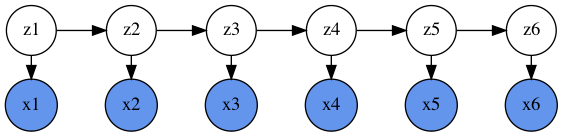

The initial distribution of the latent variable is also given as a gaussian distribution.
$$
p(z_1) = \mathcal{N}(z_1 \mid \mu_0, P_0)
$$
$P_0^{-1} = 0$ means that there is no prior information.

There is another variant of LDS with observable external input $u$.
$$
\begin{array}{ll}
z_n = A z_{n-1} + B u_n + w_n & w_n \sim \mathcal{N}(w_n \mid 0, \Gamma) \\
x_n = C z_n     + D u_n + v_n & v_n \sim \mathcal{N}(v_n \mid 0, \Sigma)
\end{array}
$$

For this competition, transition process between waypoints can be modeled as the following LDS,
$$
\begin{array}{ll}
z_n = z_{n-1} + \Delta z_n + w_n & w_n \sim \mathcal{N}(w_n \mid 0, \Gamma) \\
x_n = z_n     + v_n              & v_n \sim \mathcal{N}(v_n \mid 0, \Sigma)
\end{array}
$$
Therefore, true waypoint position (the latent variable of LDS) can be estimated by inference of LDS called the Kalman filter and smoother.

| symbol | description | |
|---|---|:---:|
| $z_n$        | true waypoint position | (unknown) | 
| $\Delta z_n$ | relative position prediction of sensor model between two waypoints | (known) |
| $w_n$        | prediction error of sensor model | (unknown) |
| $x_n$        | prediction of wifi model | (known) |
| $v_n$        | prediction error of wifi model | (unknown) |

## Inference of LDS

The recurrence formula of the Kalman filter and smoother is given by following equations.
(See [the Bishop's PRML book](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/) for derivation).

#### Kalman filter
$$
p(z_n \mid x_{1:n}) = \mathcal{N}(z_n \mid \mu_n, V_n) \\
p(z_{n+1} \mid x_{1:n}) = \mathcal{N}(z_{n+1} \mid A \mu_n, P_n)
$$

$$
K_n   = P_{n-1} C^T (C P_{n-1} C^T + \Sigma)^{-1} \\
\mu_n = A \mu_{n-1} + K_n (x_n - C A \mu_{n-1}) \quad (n \neq 1) \\
V_n   = (I - K_n C) P_{n-1} \\
P_n   = A V_n A^T + \Gamma  \\
\mu_1 = \mu_0 + K_1 (x_1 - C \mu_0)
$$

#### Kalman smoother (Rauch-Tung-Striebel smoother)
$$
p(z_n \mid x_{1:N}) = \mathcal{N}(z_n \mid \hat{\mu}_n, \hat{V}_n) 
$$

$$
J_n = V_n A^T (P_n)^{-1} \\
\hat{\mu}_n = \mu_n + J_n (\hat{\mu}_{n+1} - A \mu_n) \quad (n \neq N) \\
\hat{V}_n   = V_n + J_n (\hat{V}_{n+1} - P_n) J_n^T   \quad (n \neq N) \\
\hat{\mu}_N = \mu_N \\
\hat{V}_N   = V_N
$$

The distribution of the latent variable obtained by the Kalman smoother is the posterior distribution with all observation (including future information).

And, the joint distribution of the latent variables can also be expressed by Bayes' theorem as follows,
$$
p(z_1, \cdots, z_N \mid x_1, \cdots, x_N) \propto p(z_1, \cdots, z_N, x_1, \cdots, x_N) \\
= p(z_1) p(x_1 \mid z_1) \prod_{n=2}^{N} p(z_n \mid z_{n-1}) p(x_n \mid z_n)
$$

$$
\ln p(z_1, \cdots, z_N \mid x_1, \cdots, x_N)
= - \frac{1}{2} \left\{
(z_1 - \mu_0)^T P_0^{-1} (z_1 - \mu_0) + (x_1 - C z_1)^T \Sigma^{-1} (x_1 - C z_1) + 
\sum_{n=2}^{N} \left[ (z_n - A z_{n-1})^T \Gamma^{-1} (z_n - A z_{n-1}) + (x_n - C z_n)^T \Sigma^{-1} (x_n - C z_n) \right]
\right\} + \text{const.}
$$

Since the joint distribution of the latent variables is a multivariate gaussian distribution,
the logarithm of the probability density function is quadratic with respect to the latent variables.
Therefore, the logarithm of the probability density function can be written as
$$
\ln p(z_1, \cdots, z_N \mid x_1, \cdots, x_N) = - \frac{1}{2} (Z - Z^{*})^T Q (Z - Z^{*}) + \text{const.}
$$

Here, $Z^{*}$ is the posterior mean of the joint distribution, and $Z^{*}$ is obtained by minimizing the following quadratic function.
$$
L(z_1, \cdots, z_N) = (z_1 - \mu_0)^T P_0^{-1} (z_1 - \mu_0) + (x_1 - C z_1)^T \Sigma^{-1} (x_1 - C z_1) + 
\sum_{n=2}^{N} \left[ (z_n - A z_{n-1})^T \Gamma^{-1} (z_n - A z_{n-1}) + (x_n - C z_n)^T \Sigma^{-1} (x_n - C z_n) \right]
$$

For this competition, by assuming $P_0^{-1} = 0$, the logarithm of the joint distribution is expressed as follows,
$$
\ln p(z_1, \cdots, z_N \mid x_1, \cdots, x_N, \Delta z_2, \cdots, \Delta z_N) = - \dfrac{1}{2} \left\{
(x_1 - z_1)^T \Sigma^{-1} (x_1 - z_1) + \sum_{n=2}^{N} \left[ (z_n - (z_{n-1} + \Delta z_n))^T \Gamma^{-1} (z_n - (z_{n-1} + \Delta z_n)) + (x_n - z_n)^T \Sigma^{-1} (x_n - z_n) \right]
\right\} + \text{const.}
$$

The advantage of using Kalman filter and smoother is that the computational complexity of inference is reduced from cubic to linear with respect to length of the sequence ($N$).
However, by using a sparse matrix solver, it is possible to obtain linear order complexity even with the direct method.
[The cost minimization notebook](https://www.kaggle.com/saitodevel01/indoor-post-processing-by-cost-minimization) solves the posterior mean directly.

## Parameters of LDS

$\Gamma$ and $\Sigma$ are the parameters of the above LDS model.
The definition of these parameters is the variance of the prediction error.
$$
\Gamma = \mathbb{E}[w_n w_n^T] \\
\Sigma = \mathbb{E}[v_n v_n^T]
$$
These parameters determine which of two models, wifi and sensor, to prioritize.

And treating these parameters as constant values doesn't lead to the best results
because the variance of wifi models is greatly depending on paths and timestamps.
I think proper error estimation of machine learning models is another key technique to capture this competition.